In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
from cebra_utils import *
from vit_pytorch import ViT
import pandas as pd

data_path = '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/GRL3_2023-07-13_1'

In [2]:
## Given the path to a tif file, return that as a 3d numpy array
# @param path: path to tif file
# @return: 3d numpy array, first array is time dimension
def load_tif(path):
    img = cv2.imreadmulti(path, flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH))[1]
    img = np.array(img)
    return img

## Loads the brain data from a given trial
def load_brain_data(parent_directory, trial_num, type='gcamp'):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '/brain/' + type + '.tif')
    data = load_tif(data_path)
    return data

def load_pose_data(parent_directory, trial_num):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '/anipose/videos/pose-3d/vid.csv')
    data = pd.read_csv(data_path)
    data = data.to_numpy()
    return data

## Go through all trials and load the brain data for each trial
def load_all_brain_data_trials(parent_directory, type='gcamp'):
    # Get the number of trials
    num_trials = len([x for x in os.listdir(parent_directory) if 'trial_' in x])
    # Load the data
    return np.array([load_brain_data(parent_directory, trial_num, type) for trial_num in range(num_trials)])
    
## Takes a numpy array in and returns a memory mapped numpy array
# @param arr: numpy array to be memory mapped
# @param path: path to save the memory mapped array to
# @return: memory mapped numpy array
def memmap(arr, path):
    # Save the array
    np.save(path, arr)
    # Load the array
    return np.load(path, mmap_mode='r')

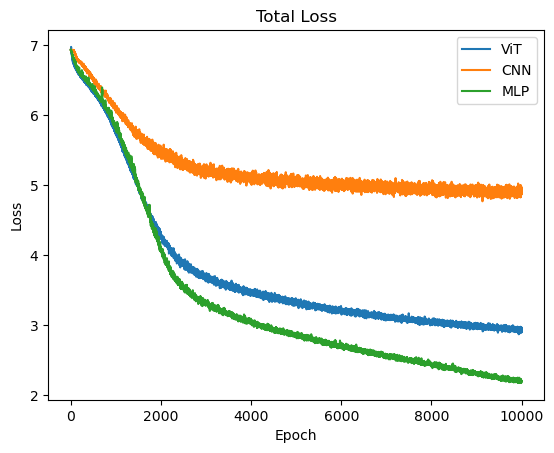

In [3]:
# append parent directory to sys path
sys.path.append('..')
ViT_CEBRA = torch.load('../Models/modelViT-offset1.pth')
CNN_CEBRA = torch.load('../Models/modelCNN.pth')
MLP_CEBRA = torch.load('../Models/modelMLP.pth')
# plot all their losses
plt.plot(ViT_CEBRA.log['total'])
plt.plot(CNN_CEBRA.log['total'])
plt.plot(MLP_CEBRA.log['total'])
plt.legend(['ViT', 'CNN', 'MLP'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.show()

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('ViT Parameters:', count_parameters(ViT_CEBRA))
print('CNN Parameters:', count_parameters(CNN_CEBRA))
print('MLP Parameters:', count_parameters(MLP_CEBRA))

ViT Parameters: 1201673
CNN Parameters: 10969
MLP Parameters: 1314057


In [5]:
count_parameters(cebra.models.init("ViT-16-v1", 64, 4, 8, True))

1201672

In [6]:
# Load data from different session
data_path = "/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/GRL3_2023-07-17_1"
brain_data = [load_brain_data(data_path, x) for x in range(10)]
flattened_brain_data = np.concatenate(brain_data, axis=0)
flattened_brain_images = np.lib.stride_tricks.sliding_window_view(flattened_brain_data, (3, 64, 64)).squeeze()
tensor_data = torch.from_numpy(flattened_brain_images).float()
tensor_data = tensor_data.moveaxis(1, 2)
eval_model = model.model.eval()
embedding = []
for i in range(28 * 2):
    embedding.extend(eval_model(tensor_data[i*10: (i+1) * 10].to('cuda')).detach().cpu().numpy())

/tmp/ipykernel_875244/2148643653.py:6: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  tensor_data = torch.from_numpy(flattened_brain_images).float()


NameError: name 'model' is not defined

In [ ]:
## Loads test data in format for the model to use
# @param path: path to the data
# @param trials: list of trials to load
# @param offset_size: size of the receptive field
# @return: returns a (n * 288) x 64 x 64 x 3 tensor of brain data
def load_test_brain_data(path, trials, offset_size):
    brain_data = [load_brain_data(path, x) for x in trials]
    flattened_brain_data = np.concatenate(brain_data, axis=0)
    flattened_brain_data = np.array([cv2.resize(img, (64, 64)) for img in flattened_brain_data])
    flattened_brain_images = np.lib.stride_tricks.sliding_window_view(flattened_brain_data, (offset_size, 64, 64)).squeeze()
    tensor_data = torch.from_numpy(flattened_brain_images).float()
    tensor_data = tensor_data.moveaxis(1, 2)
    return tensor_data

## Given a model and a tensor of data calculates the embeddings with given batch size and returns them
# @param model: model to use to calculate embeddings
# @param input: tensor of data to calculate embeddings for
# @param batch_size: batch size to use when calculating embeddings
# @return: returns a list of embeddings
def batch_process_embeddings(model, input, batch_size):
    for i in range(len(input) // batch_size):
        if i == 0:
            embeddings = model(input[i * batch_size: (i+1) * batch_size].to('cuda')).detach().cpu().numpy()
        else:
            embeddings = np.concatenate((embeddings, model(input[i * batch_size: (i+1) * batch_size].to('cuda')).detach().cpu().numpy()), axis=0)
    return embeddings

In [ ]:
test_tensor = load_test_brain_data("/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/GRL3_2023-07-17_1", [1, 2, 3, 4], 3)

In [ ]:
embeddings = batch_process_embeddings(model.model.eval(), test_tensor, 10)

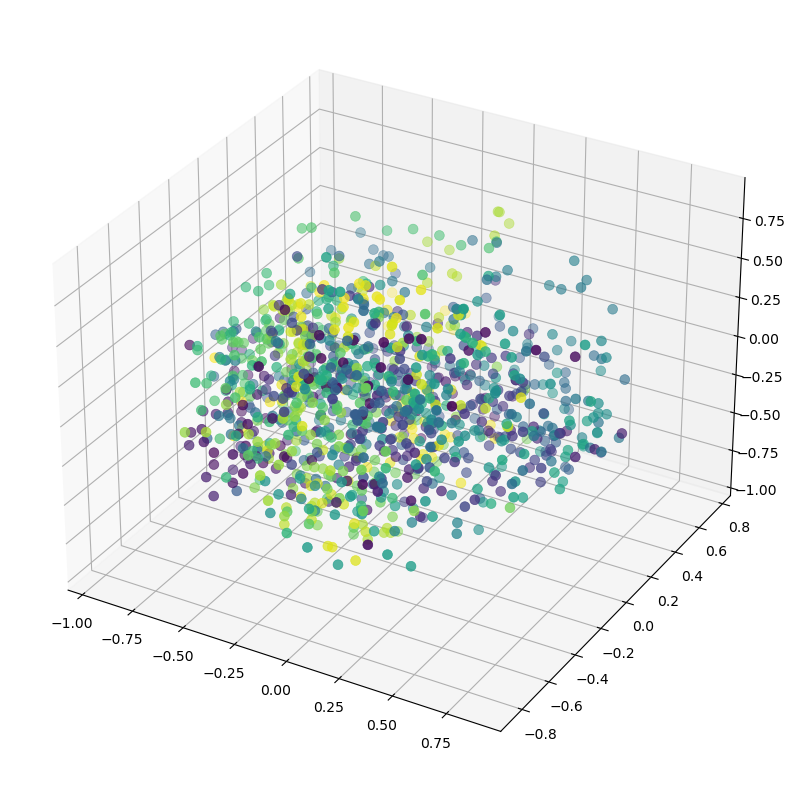

In [ ]:
embedding = np.array(embeddings)
# make a 3d scatter plot of the first 3 dimensions of the embedding
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], cmap='viridis', linewidth=0.5, c=(np.arange(len(embedding)) % 288), s=50)
plt.show()

In [ ]:
ViT = [child2 for child2 in [child for child in eval_model.children()][0].children()][1]


In [ ]:
tensor_data = test_tensor.movedim(1,2)

NameError: name 'test_tensor' is not defined

In [ ]:
from vit_pytorch.recorder import Recorder
ViT = Recorder(ViT)


In [ ]:
emb, attn = ViT(tensor_data[0:288].to('cuda'))

In [ ]:
## Input is attentions maps from ViT recorder
# shape is (depth ,num_heads, num_steps, num_steps)
def rollout(attn):
    # Take the mean across all heads (Subject to change)
    attn_mean = attn.mean(dim=1)

    # take max across all heads instead
    attn_mean = attn.max(dim=1)[0]

    # add identity adn normalize
    residual_attn = torch.eye(attn_mean.shape[-1]).unsqueeze(0).to('cpu') + attn_mean
    residual_attn = residual_attn / residual_attn.sum(dim=-1).unsqueeze(-1)
    # convert to numpy
    aug_attn_mat = residual_attn.detach().cpu().numpy()
    #Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, 1:].reshape(grid_size, grid_size)
    return mask

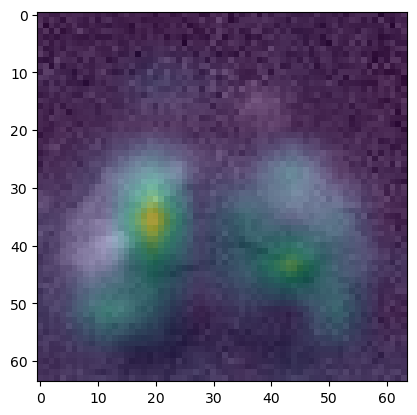

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

masks = [rollout(map.to('cpu')) for map in attn]
attention_video =  np.array([cv2.resize(mask, (64, 64)) for mask in masks])
brain_video =  tensor_data[0:288, 0].detach().cpu().numpy()

frames = [] # for storing the generated images
fig = plt.figure()
for i in range(len(attention_video)):
    frames.append([plt.imshow(attention_video[i],animated=True), plt.imshow(brain_video[i], cmap='gray', alpha=0.5, animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')
plt.show()